<a href="https://colab.research.google.com/github/heokyeongju/OpensourceAI/blob/main/4_K_median_%EA%B5%B0%EC%A7%91%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 2. Numpy Basis**
# Homework 2. K Median 군집화

### _Objective_
1. 스스로 처음부터 끝까지 군집화 알고리즘을 구현하는 데에 집중합니다. <br>
2. Noise에 좀더 강건한 K-Median 군집화를 배워봅니다.. <br>

╚═════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

## 예제 데이터 )  이상값이 존재하는 데이터셋

In [2]:
# 예제 데이터 셋 
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmedian_dataset.csv
dataset = np.loadtxt("./kmedian_dataset.csv",delimiter=',')

--2021-10-20 13:23:38--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmedian_dataset.csv
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.144.77
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.144.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 546 [text/csv]
Saving to: ‘kmedian_dataset.csv.3’

kmedian_dataset.csv 100%[===================>]     546  --.-KB/s    in 0s      

2021-10-20 13:23:39 (23.1 MB/s) - ‘kmedian_dataset.csv.3’ saved [546/546]



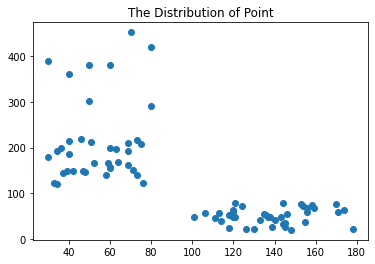

In [3]:
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0], dataset[:,1])
plt.show()

우리는 직관적으로 보았을 때, 크게 2개의 군집 혹은 3개의 3개의 군집으로 나누어 볼 수 있습니다. 예를 들어 아래와 같은 중심을 기준으로 나누어 볼 수 있습니다.

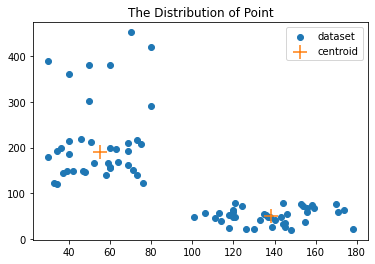

In [4]:
# 예제 데이터셋 시각화
centers = np.array([[ 55. , 190. ],
                    [138.5,  50. ]])
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1],label='dataset')
plt.scatter(centers[:,0],centers[:,1],
            s=200, label="centroid", marker='+')
plt.legend()
plt.show()

우리는 좌측 상단의 값들이 중심점으로부터 멀게 존재합니다. 이런 데이터들을 *이상값(outlier)* 라고 부릅니다. 이런 값들은 머신러닝이 동작하는 걸 방해하는 요인이 됩니다. 

# \[ 문제 \]

아래는 수업 중에 작성하였던 코드입니다. 

In [5]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

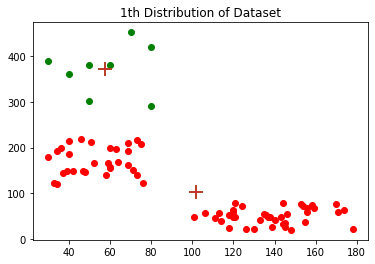

array([[101.82857143, 102.3       ],
       [ 57.5       , 371.875     ]])

In [6]:
cluster_kmeans(dataset,2)

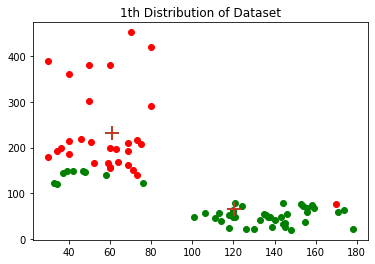

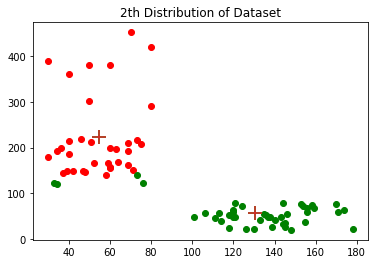

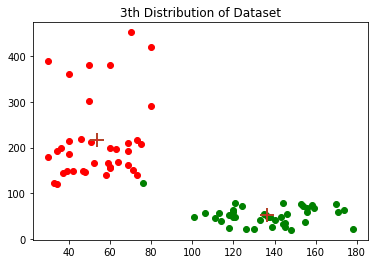

array([[ 53.83783784, 215.94594595],
       [136.48780488,  52.34146341]])

In [7]:
# 군집은 랜덤하게 계속 잡히지만, 
# 우리가 원하지 않은 형태의 군집으로 잡힙니다.
cluster_kmeans(dataset,2)

> 군집은 랜덤하게 계속 잡히지만, 우리가 원하지 않은 형태의 군집으로 잡힙니다. K-Means 알고리즘은 이와 같이 이상값들에 취약한 경향을 띕니다. 이런 이상값이 많은 데이터셋에서는 수정된 형태의 알고리즘을 이용합니다.

## K-Median 알고리즘 구현하기

K-median 알고리즘은 K-Means 알고리즘의 변형된 형태입니다. K-Median 알고리즘은 K-Means와 동일하게 중심점으로부터 각 데이터의 거리를 측정 후, 중심점의 위치를 바꾸어 가는 형태로 학습을 합니다. 이 때 크게 2가지 점에서 다릅니다. 


1. 거리 함수의 차이 

K-means 알고리즘에서는 아래와 같은 수식을 이용하였습니다.

$$
point1 = (x_1,y_1), point2 = (x_2,y_2)\mbox{일 때}\\
distance\_between\_point1\_and\_point2 = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}
$$

K-Median 알고리즘에서는 위의 수식이 아닌 아래의 수식을 이용합니다.

$$
point1 = (x_1,y_1), point2 = (x_2,y_2)\mbox{일 때}\\
distance\_between\_point1\_and\_point2 = |x_1-x_2| + |y_1-y_2|
$$

2. 중심점의 기준을 **평균값**이 아닌 **중앙값**으로 대체

K-Means 알고리즘에서는 같은 군짐들의 점을 모아, **점들의 좌표 평균값**으로 중심점을 이동합니다. 대신 K-Median 알고리즘에서는 **점들의 중앙값**으로 중심점을 이동합니다.

In [8]:
def cluster_kmedians(dataset, k):    
  
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    

    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point

        # dists를 구할 때 절대값의 합으로
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = abs(diff_mat).sum(axis=-1)
        

        cluster_per_point = dists.argmin(axis=0)
        
    
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()    
    return centroids

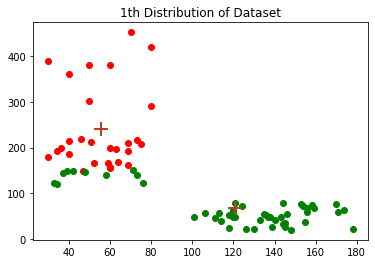

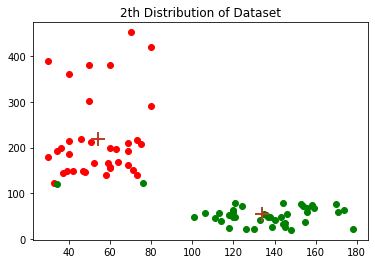

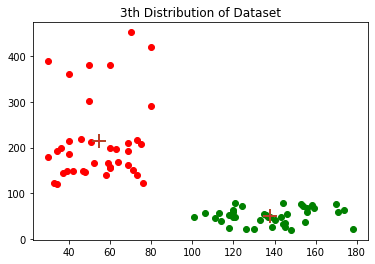

array([[ 54.42105263, 213.47368421],
       [138.        ,  50.6       ]])

In [9]:
# 아래와 같은 결과가 나오면 됩니다
cluster_kmedians(dataset, 2)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/04

---